In [30]:
import psutil

def get_free_memory():
    memory = psutil.virtual_memory()
    return memory.available / (1024.0 ** 3)  # Convert bytes to gigabytes

print(f"Free CPU Memory: {get_free_memory():.2f} GB")

Free CPU Memory: 643.37 GB


In [31]:
import torch
torch.backends.cuda.matmul.allow_tf32 = True
from datasets import Dataset
import os

In [32]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit

tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = WhitespaceSplit()

In [33]:
tokenizer_path = "WordLevel_tokenizer_trained_InterPro.json"
tokenizer = tokenizer.from_file(tokenizer_path)
tokenizer.enable_truncation(512)

In [34]:
tokenizer.get_vocab_size()


544998

In [35]:
test = tokenizer.encode("WP_265490204 WP_206642677 WP_053312998 WP_251959347 WP_000076573 WP_227526754 WP_218401808 WP_106925592")
test.ids

[1, 2966, 754, 2545, 196, 9231, 2817, 7418, 2526, 2]

In [36]:
import csv

defense_ips = []
directory = "/home/toibazd/Defense_InterPros/"
file_list = os.listdir(directory)

for file in file_list:
    print(file)
    file_path = os.path.join(directory, file)
    with open(file_path, 'r', newline='') as infile:
        reader = csv.reader(infile, delimiter = "\t")
        next(reader)
        for row in reader:
            ip = row[0]
            defense_ips.append(ip)

LIT_IP.tsv
Toxin-antitoxin.tsv
CRISPR_IP.tsv
BREX_IP.tsv
DISARM_IP.tsv
Druantia.tsv
Abortive_infection.tsv
Kiwa_IP.tsv


In [37]:
defense_ips = ["IPR005510", "IPR005537", "IPR017546", "IPR017547", "IPR047721", "IPR032359", "IPR019504"]

In [38]:
print("Defense IPs number: ", len(defense_ips))

Defense IPs number:  7


In [39]:
from collections import defaultdict
import csv
from tqdm.auto import tqdm
import numpy as np

data_dict = defaultdict(list)

with open("/home/toibazd/Prot2IP.tsv", "r") as tsvfile:
    reader = csv.reader(tsvfile, delimiter = "\t")
    for row in tqdm(reader):
        key = row[0].split("prot_")[1].split(".")[0]
        iprs = eval(row[1])

        # Save only if there are filtered InterPro IDs
        for ip in iprs:
            if ip in defense_ips:
                data_dict[key].append(ip)


0it [00:00, ?it/s]

In [40]:
unique_defense = set()

# Iterate through each value list in the dictionary and add its elements to the set
for value_list in data_dict.values():
    unique_defense.update(value_list)

# Convert the set to a list if needed
unique_defense = list(unique_defense)

In [41]:
len(unique_defense)

5

In [42]:
from sklearn.preprocessing import MultiLabelBinarizer
enc = MultiLabelBinarizer()
one_hot_encoded = enc.fit_transform(data_dict.values())
one_hot_encoded_dict = {key: value for key, value in zip(data_dict.keys(), one_hot_encoded)}

print(len(one_hot_encoded_dict.keys()))

48


In [43]:
one_hot_encoded.shape

(48, 5)

In [44]:
unique_defense = ["IPR005510", "IPR005537", "IPR017546", "IPR017547", "IPR047721", "IPR032359", "IPR019504"]

In [45]:
import os
import random
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

directory = '/ibex/user/toibazd/InterPro/'
one_hot_encoded_sentences = {}

sentence_length = 40

# Set random seed for reproducibility
random.seed(42)

# Randomly choose 1000 files with seed 42
selected_files = os.listdir(directory)


# Define a function to process a file
def process_file(filename, IP):
    sentences = []

    filepath = os.path.join(directory, filename)

    with open(filepath, 'r') as file:
        content = file.read()
        words = content.strip().split()

        # Check if the key is in the file
        for i in range(19, len(words)-20):
            # Shuffle the indices of the words containing the key
            if IP in data_dict[words[i]]:
                if len(words) - i >= 21:
                    sentence = " ".join(words[i - 19:i + sentence_length - 19])
                    sentences.append(sentence)
    return sentences


# Iterate over keys
for IP in tqdm(unique_defense):
    one_hot_encoded_sentences[IP] = []


    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = [executor.submit(process_file, filename, IP) for filename in selected_files]
        for future in futures:
            sentences = future.result()
            one_hot_encoded_sentences[IP].extend(sentences)

    # Break if the required number of sentences per key is reached


  0%|          | 0/7 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [16]:
# for key, values in one_hot_encoded_sentences.items():
#     print(len(values))

In [17]:
# import json

# with open('BERT_sanity_check_defense_DNN_senteces.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences, f)

In [18]:
import json
with open('BERT_sanity_check_defense_DNN_senteces.json', "r") as f:
    one_hot_encoded_sentences = json.load(f)

In [20]:
for key, value in one_hot_encoded_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR005510 611
IPR005537 1218
IPR017546 0
IPR017547 0
IPR047721 1405
IPR032359 562
IPR019504 200


In [21]:
one_hot_encoded_sentences = {key: value for key, value in one_hot_encoded_sentences.items() if value}
len(one_hot_encoded_sentences)

5

In [22]:
matching_string = one_hot_encoded_sentences.values()
len(matching_string)

5

In [23]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

3996

In [24]:
count= 0
for string in matching_string:
    words = string.split(" ")
    if not words[19] in data_dict.keys():
        print("False")
    else:
        count+=1
print(count)

3996


In [25]:
from transformers import BertModel

# Check if CUDA is available and choose device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = "/home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final"

model = BertModel.from_pretrained(model_path).cuda()
model.pooler = None
model.eval()

[2024-03-27 13:44:17,513] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Some weights of BertModel were not initialized from the model checkpoint at /home/toibazd/Data/BERT/BERT_context_pretrained_InterPro_final and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(544998, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [26]:
print(one_hot_encoded[1].shape)

(141,)


In [27]:
batch_size = 128 # Define your batch size
embeddings = []
labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]

    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)

    # Convert lists to tensors and move to device
    input_ids = torch.tensor(input_ids_list).cuda()
    attention_mask = torch.tensor(attention_mask_list).cuda()

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
    hidden_states = outputs.last_hidden_state
    relevant_hidden_states = hidden_states[:, 20, :]  # Extract the 20th token's hidden state
    
    for j in range(len(batch_sentences)):
        embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        labels.append(indicator)

# Ensure order in embeddings matches order in labels

# Now embeddings and labels are stored on the CPU


100%|██████████| 32/32 [00:00<00:00, 50.60it/s]


In [27]:
def calculate_pos_weights(class_counts):
    pos_weights = np.ones_like(class_counts)
    
    neg_counts = [len(embeddings)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
      pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)
class_counts = np.array(labels).sum(axis=0)
pos_weights = calculate_pos_weights(class_counts) 

In [29]:
import numpy as np
import umap
import matplotlib.pyplot as plt


reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(embeddings)

# Plot the reduced embeddings with corresponding labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)

# Add labels to the points
for i, label in enumerate(labels):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label)

plt.title('UMAP Visualization of Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


2024-03-27 13:48:51.026029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:48:52.690932: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 13:48:53.421858: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 13:48:58.276170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3996,) + inhomogeneous part.

In [28]:
pos_weights

tensor([ 12., 118.,  93., 105.,  26., 117.,  44.,  58., 118.,  39., 103., 114.,
        118., 118., 118.,  62.,  73., 118., 118.,  51., 103., 118., 855., 220.,
         90., 118., 118., 118.,  58., 118., 116.,  78., 118.,  95., 118., 118.,
        118., 118., 118., 163., 351., 118., 225.,  82., 104.,  58., 427.,  83.,
        177., 202., 116., 598., 664., 118., 569., 118., 118., 118., 118., 277.,
        100., 118., 213., 362., 629., 362., 118., 118., 154., 104., 748.,  58.,
        118., 112., 118.,  55., 111., 114., 112., 113., 118.,  28.,  88., 118.,
        118., 118., 118., 118.,  63., 118., 118.,  79., 172., 229., 118., 118.,
        118., 116., 118., 118., 118., 118., 118., 118.,  89., 351., 341., 478.,
        118., 114., 112., 629., 189., 118., 123., 141., 118., 118., 118., 118.,
        118.,  59.,  55., 520., 116., 117., 118., 460., 118., 118., 118., 118.,
        167., 116., 118., 146., 362., 704., 284., 331., 248.])

In [29]:
import random

random.seed(42)
# Zip the lists together
combined = list(zip(embeddings, labels))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list
embeddings, labels = zip(*combined)



In [30]:
model.to("cpu")
torch.cuda.empty_cache()

In [31]:
import torch.nn as nn

class Classification_V0(nn.Module):
    def __init__(self, input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob):
        super(Classification_V0, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_hidden)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(first_hidden, second_hidden)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(second_hidden, last_hidden)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(last_hidden, output_dim)
        
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = 256
first_hidden = 128
second_hidden = 64
last_hidden = 32
output_dim = 141
dropout_prob = 0.25

clf_model = Classification_V0(input_dim, first_hidden, second_hidden, last_hidden, output_dim, dropout_prob)


In [32]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

batch_size = 128
def data_generator(embeddings, labels, batch_size):
    num_samples = len(embeddings)
    for i in range(0, num_samples, batch_size):
        batch_embeddings = embeddings[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        yield batch_embeddings, batch_labels


optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)

In [33]:
import numpy as np

num_epochs = 20
epoch_loss = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")
    
    # Initialize data generator
    generator = data_generator(embeddings, labels, batch_size)
    train_loss = 0
    # Iterate over batches
    for batch_embeddings, batch_labels in tqdm(generator, desc="Training Batches", leave=False):
        
        optimizer.zero_grad()
        
        # Convert data to tensors

        batch_embeddings_tensor = torch.stack(batch_embeddings)
        batch_labels = np.array(batch_labels)
        batch_labels_tensor = torch.tensor(batch_labels, dtype = torch.float32)
        outputs = clf_model(batch_embeddings_tensor)
        loss = criterion(outputs, batch_labels_tensor)
#         print(loss)
        train_loss+=loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    scheduler.step()
    epoch_loss.append(train_loss/(len(embeddings)/batch_size))
    print(train_loss/(len(embeddings)/batch_size))
print("Training finished.")

Epoch 1/20:


Training Batches: 0it [00:00, ?it/s]

1.3106584104215113
Epoch 2/20:


Training Batches: 0it [00:00, ?it/s]

0.9699922356224044
Epoch 3/20:


Training Batches: 0it [00:00, ?it/s]

0.7606676960444941
Epoch 4/20:


Training Batches: 0it [00:00, ?it/s]

0.6532222123741557
Epoch 5/20:


Training Batches: 0it [00:00, ?it/s]

0.580287893570085
Epoch 6/20:


Training Batches: 0it [00:00, ?it/s]

0.5271284444383637
Epoch 7/20:


Training Batches: 0it [00:00, ?it/s]

0.48680812988128497
Epoch 8/20:


Training Batches: 0it [00:00, ?it/s]

0.45285969985041574
Epoch 9/20:


Training Batches: 0it [00:00, ?it/s]

0.42433568690809087
Epoch 10/20:


Training Batches: 0it [00:00, ?it/s]

0.39772081331364595
Epoch 11/20:


Training Batches: 0it [00:00, ?it/s]

0.3823424676863477
Epoch 12/20:


Training Batches: 0it [00:00, ?it/s]

0.3780274445672265
Epoch 13/20:


Training Batches: 0it [00:00, ?it/s]

0.3772466215129053
Epoch 14/20:


Training Batches: 0it [00:00, ?it/s]

0.37474336605846925
Epoch 15/20:


Training Batches: 0it [00:00, ?it/s]

0.3722346321679419
Epoch 16/20:


Training Batches: 0it [00:00, ?it/s]

0.3633972267258443
Epoch 17/20:


Training Batches: 0it [00:00, ?it/s]

0.3673929516961042
Epoch 18/20:


Training Batches: 0it [00:00, ?it/s]

0.35740000962753593
Epoch 19/20:


Training Batches: 0it [00:00, ?it/s]

0.35964498745049567
Epoch 20/20:


Training Batches: 0it [00:00, ?it/s]

0.36317314866526546
Training finished.


In [34]:
# directory = '/ibex/user/toibazd/InterPro_annotated_genomes_for_testing/'
# one_hot_encoded_sentences_2 = {}

# sentence_length = 40
# sentence_per_IP = 50
# selected_files = os.listdir(directory)

# total_sentences = sum(len(sentences) for sentences in one_hot_encoded_sentences.values())

# # Iterate over keys
# for IP in tqdm(unique_defense):
#     one_hot_encoded_sentences_2[IP] = []
#     sentences_count=0
    
#     # Iterate over selected files
#     for filename in selected_files:
#         filepath = os.path.join(directory, filename)

#         with open(filepath, 'r') as file:
#             content = file.read()
#             words = content.strip().split()

#             # Check if the key is in the file
#             for i in range(19, len(words)-20):
#                 # Shuffle the indices of the words containing the key
#                 if IP in data_dict[words[i]]:
#                     if len(words) - i >= 21:
#                         sentence = " ".join(words[i - 19:i + sentence_length - 19])
#                         one_hot_encoded_sentences_2[IP].append(sentence)
#                         sentences_count += 1
#                         if sentences_count>=sentence_per_IP:
#                             break
#         if sentences_count>=sentence_per_IP:
#             break
#     print(sentences_count)
            


In [35]:
# for key, value in one_hot_encoded_sentences_2.items():
#     print(len(value))

In [36]:
# import json

# with open('BERT_sanity_check_defense_DNN_senteces_testing.json', 'w') as f:
#     json.dump(one_hot_encoded_sentences_2, f)

In [37]:
with open('BERT_sanity_check_defense_DNN_senteces_testing.json', "r") as f:
    test_sentences = json.load(f)

In [38]:
test_sentences = {key: value for key, value in test_sentences.items() if value}
len(test_sentences)

141

In [39]:
for key, value in test_sentences.items():
    print(key, end=" ")
    print(len(value))

IPR028629 50
IPR007712 50
IPR030987 5
IPR007337 50
IPR017034 50
IPR022597 50
IPR048242 50
IPR013421 23
IPR019092 8
IPR019117 3
IPR022541 50
IPR021228 50
IPR006482 50
IPR019857 50
IPR010160 5
IPR021127 50
IPR013444 2
IPR018669 50
IPR015090 50
IPR025935 50
IPR025253 50
IPR023843 14
IPR017277 50
IPR017574 10
IPR021124 50
IPR044054 50
IPR047679 50
IPR009320 50
IPR013492 50
IPR013403 13
IPR026262 50
IPR025940 50
IPR005510 50
IPR010156 50
IPR013415 4
IPR048067 16
IPR013487 2
IPR021558 50
IPR019851 50
IPR031856 50
IPR010149 50
IPR010144 50
IPR025211 50
IPR047976 50
IPR013419 5
IPR013397 50
IPR013399 50
IPR013382 50
IPR039060 50
IPR019239 50
IPR010179 50
IPR035424 6
IPR010147 50
IPR014174 31
IPR002850 50
IPR039052 50
IPR019855 50
IPR013410 12
IPR025897 50
IPR019238 50
IPR010148 50
IPR016581 4
IPR013430 50
IPR013343 50
IPR011664 50
IPR031709 32
IPR013395 50
IPR013337 25
IPR019504 32
IPR010146 50
IPR024640 38
IPR019858 50
IPR010155 50
IPR011660 50
IPR018654 50
IPR006442 50
IPR010173 50
IPR005537

In [40]:
matching_string = test_sentences.values()
len(matching_string)

141

In [41]:
matching_string = [item for sublist in matching_string for item in sublist]
len(matching_string)

5313

In [42]:
from bertviz import model_view

batch_size = 128 # Define your batch size
# model.cuda()
test_embeddings = []
test_labels = []

# Define your data iterator in batches
for i in tqdm(range(0, len(matching_string), batch_size)):
    batch_sentences = matching_string[i:i+batch_size]
    batch_inputs = tokenizer.encode_batch(batch_sentences)
    input_ids_list = []
    attention_mask_list = []

    for encoding in batch_inputs:
        input_ids_list.append(encoding.ids)
        attention_mask_list.append(encoding.attention_mask)
    # Convert lists to tensors and move to device
    try:
        input_ids = torch.tensor(input_ids_list)
    except:
        for ins in input_ids_list:
            if len(ins)!=42:
                print(len(ins))
                print(ins)
    attention_mask = torch.tensor(attention_mask_list)

    with torch.inference_mode():
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions = True)
    hidden_states = outputs.last_hidden_state
    attentions = outputs.attentions[-1]
    relevant_hidden_states = hidden_states[:, 20, :] 

    
#     for i in range(len(batch_sentences)):
#         if i < 20:
#             att = []
#             extracted_tensor = attentions[i, :, :, :]
#             extracted_tensor = extracted_tensor.unsqueeze(0)
#             print(extracted_tensor.shape)
#             att.append(extracted_tensor)

#             tokens = "[CLS] "+tokenizer.decode(input_ids_list[i])+" [SEP]"
#             tokens = tokens.split(" ")
#             model_view(att, tokens)
    
    for j in range(len(batch_sentences)):

        test_embeddings.append(relevant_hidden_states[j].cpu())
        indicator = batch_sentences[j].split()[19]
        test_labels.append(one_hot_encoded_dict[indicator])


  0%|          | 0/42 [00:00<?, ?it/s]

In [43]:
tokenizer.decode([0,12,12,12,12,
                 ])

'WP_072018053 WP_072018053 WP_072018053 WP_072018053'

In [44]:
model.to("cpu")
torch.cuda.empty_cache()

In [45]:
clf_model.eval()

Classification_V0(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=32, out_features=141, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [97]:
generator = data_generator(test_embeddings, test_labels, batch_size)


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
all_predictions = []
all_labels = []
all_probs = []

for batch_embeddings, batch_labels in tqdm(generator, desc="Evaluation Batches", leave=False):
    batch_embeddings_tensor = torch.stack(batch_embeddings)
    batch_labels = np.array(batch_labels)
    logits = clf_model(batch_embeddings_tensor)
    predictions = torch.sigmoid(logits)
    thresholded_predictions = (predictions > 0.9).float()
    all_predictions.append(thresholded_predictions.detach().numpy())
    all_labels.append(batch_labels)
    all_probs.append(predictions.detach().numpy())


Evaluation Batches: 0it [00:00, ?it/s]

In [98]:
len(all_predictions)

42

In [99]:
len(all_labels[-1])
    

65

In [100]:
print(all_predictions[0].shape)

(128, 141)


In [101]:
print(all_labels[0].shape)

(128, 141)


In [102]:

# Concatenate predictions and labels across all batches
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)
all_probs = np.concatenate(all_probs)

In [103]:
all_labels.shape

(5313, 141)

In [104]:
from sklearn import metrics
auc_scores = []

for i in range(all_labels.shape[1]):  # Iterate over each column
    y = all_labels[:, i]
    pred_y = all_probs[:, i]

    fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
    auc_score = metrics.auc(fpr, tpr)
    auc_scores.append(auc_score)

print("AUC for each column:")
for idx, score in enumerate(auc_scores):
    print(idx,": ", score)

AUC for each column:
0 :  0.9222414933566669
1 :  0.9384875546266388
2 :  0.8994949621065511
3 :  0.999757209882214
4 :  0.9914390211327655
5 :  0.7503819114573437
6 :  0.9904451027722917
7 :  0.8978822175330903
8 :  0.8511305339160176
9 :  0.8459913486990768
10 :  0.9927635025719185
11 :  0.9760782823484704
12 :  0.9503743112293368
13 :  0.94948888466654
14 :  0.9944290328709862
15 :  0.9842561983471074
16 :  0.9770395825378643
17 :  1.0
18 :  0.9680258407752234
19 :  0.9993436420933333
20 :  0.9916992027297484
21 :  0.9427816834505036
22 :  1.0
23 :  0.9997905144963969
24 :  0.9999999999999999
25 :  0.9557096712901387
26 :  1.0
27 :  0.9834429032870986
28 :  0.9344235564933819
29 :  0.9198745962378871
30 :  1.0
31 :  0.9349787122470129
32 :  0.9637811134334029
33 :  0.9698710587617705
34 :  0.9990195705871177
35 :  0.9819722591677751
36 :  0.9928367851035531
37 :  0.990039901197036
38 :  0.9869352080562417
39 :  0.9996952104499275
40 :  1.0
41 :  0.9983697510925328
42 :  0.9998652036

In [105]:
from sklearn import metrics

y = all_labels.flatten()
pred_y = all_probs.flatten()

fpr, tpr, thresholds = metrics.roc_curve(y, pred_y)
print(metrics.auc(fpr, tpr))

0.9845080683467753


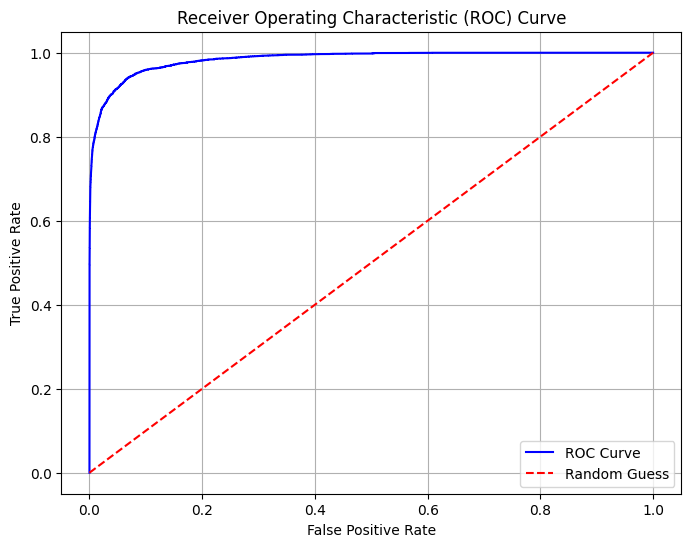

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [107]:
cl_report = multilabel_confusion_matrix(all_labels, all_predictions)
print("Classification report:")
print(len(cl_report))

Classification report:
141


In [108]:
print(cl_report[23])

[[5264   40]
 [   0    9]]


In [109]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions, zero_division=np.nan)

In [110]:
all_predictions.sum(axis=0)

array([ 94.,  36.,  76.,  52., 176.,   0.,  79.,  50.,  28.,  15.,  85.,
        59.,  58.,  35.,  65.,  93.,  96.,  51.,  40., 106.,  41.,  23.,
         5.,  49.,  66.,  96.,  24.,  64.,  50.,  10.,  50.,  41.,  84.,
        86.,  67., 107.,  41.,  84.,  46.,  21.,  18.,  51.,  16.,  84.,
        20., 106.,   4.,  50.,   8.,  50.,  25.,   9.,   4.,  37.,   4.,
        63.,  32.,  46.,  49.,  58.,  42.,  54.,  10.,   5.,   1.,   5.,
        49.,  22.,  24.,  18.,   6.,  50.,  49.,  50.,  50.,  95.,  38.,
        75.,  52.,  44.,  54., 119.,  32.,  54.,  51.,  66.,  77.,  89.,
        92.,  60.,  55.,  59.,  18.,  18.,  47.,   0.,  67.,  58.,  36.,
        31.,  27.,  56.,  45.,  54.,  50.,  19.,  12.,  12.,  30.,  28.,
        38.,   4.,  14.,  48.,  33.,  36.,  42.,  39.,  52.,  24.,  51.,
        92.,  93.,   7.,  49.,  45.,  52.,   5.,  53.,  47.,  41.,  39.,
        20.,  50.,  50.,  25.,   9.,  15.,  12.,   1.,   8.],
      dtype=float32)

In [111]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.24      0.38       390
           1       0.78      0.56      0.65        50
           2       0.55      0.69      0.61        61
           3       1.00      0.90      0.95        58
           4       0.75      0.69      0.72       190
           5        nan      0.00      0.00        50
           6       0.89      0.67      0.76       105
           7       0.98      0.49      0.65       100
           8       1.00      0.56      0.72        50
           9       0.07      0.01      0.01       150
          10       0.62      0.83      0.71        64
          11       0.66      0.78      0.72        50
          12       0.33      0.38      0.35        50
          13       1.00      0.70      0.82        50
          14       0.58      0.76      0.66        50
          15       0.81      0.85      0.83        88
          16       0.74      0.95      0.83        75
          17       0.98    

In [96]:
list(enc.classes_)[5]

'IPR006442'

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
num_classes = 83
# Compute precision, recall, and thresholds for each class
precision = dict()
recall = dict()
thresholds = dict()
average_precision = dict()

for i in range(num_classes):  # num_classes is the number of classes
    precision[i], recall[i], thresholds[i] = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
    average_precision[i] = average_precision_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average precision-recall curve and AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels.ravel(), all_predictions.ravel())
average_precision["micro"] = average_precision_score(all_labels, all_predictions, average="micro")

# Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_predictions[:, i])
    roc_auc[i] = roc_auc_score(all_labels[:, i], all_predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_predictions.ravel())
roc_auc["micro"] = roc_auc_score(all_labels, all_predictions, average="micro")

# Split classes into groups of 10
class_groups = [list(range(i, min(i + 10, num_classes))) for i in range(0, num_classes, 10)]

# Plot Precision-Recall and ROC curves for each group
for group in class_groups:
    plt.figure(figsize=(12, 6))

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.step(recall['micro'], precision['micro'], where='post', label='Micro-average Precision-Recall curve (AUPR = {0:0.2f})'
                 ''.format(average_precision["micro"]))
    for i in group:
        plt.step(recall[i], precision[i], where='post', label='Precision-recall curve of class {0} (AUPR = {1:0.2f})'
                 ''.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve (Classes {})'.format(group))
    plt.legend(loc="best")

    # Plot ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr['micro'], tpr['micro'], label='Micro-average ROC curve (AUC = {0:0.2f})'
                 ''.format(roc_auc["micro"]))
    for i in group:
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Classes {})'.format(group))
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()


In [1]:
import nltk
import sklearn

print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.5.
The scikit-learn version is 1.4.1.post1.
